In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import copy
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Версии библиотек
print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")

PyTorch: 2.9.0+cu128
Torchvision: 0.24.0+cu128
NumPy: 2.3.4
Matplotlib: 3.10.7


## Установка Seed

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Аугментация данных

In [4]:
class TwoTransform:
    # Возвращает две разные версии одного изображеня
    def __init__(self, base_transform):
        self.base = base_transform
    def __call__(self, x):
        return self.base(x), self.base(x)

# Сдвиг, кадрирование, поворот и нормализация

# Для обучения BYOL
mnist_aug = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mean и std пикселей на MNIST
])

# Для проверки линейной головы
linear_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Пример исходного и аугментированных изображений

In [5]:
mnist_ds = datasets.MNIST(root='./data', train=True, transform=None, download=True)

In [6]:
img, label = mnist_ds[0]
v1, v2 = TwoTransform(mnist_aug)(img)

def unnormalize(tensor):
    return tensor * 0.3081 + 0.1307

v1_img = unnormalize(v1).squeeze().numpy()
v2_img = unnormalize(v2).squeeze().numpy()
orig_img = transforms.ToTensor()(img).squeeze().numpy() 

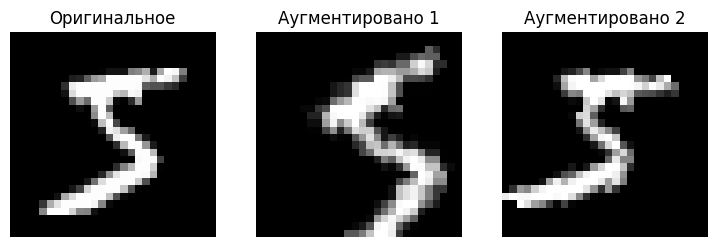

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
axes[0].imshow(orig_img, cmap='gray')
axes[0].set_title("Оригинальное")
axes[1].imshow(v1_img, cmap='gray')
axes[1].set_title("Аугментировано 1")
axes[2].imshow(v2_img, cmap='gray')
axes[2].set_title("Аугментировано 2")
for ax in axes:
    ax.axis('off')
plt.show()

## Энкодер

In [7]:
class Encoder(nn.Module):
    def __init__(self, rep_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), # 28x28
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # 14x14
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten() # 1x1
        )
        self.fc = nn.Linear(128, rep_dim) # 1x1x128 -> 128
    def forward(self, x): return self.fc(self.net(x))

## Проекционная и предикторные головы

In [8]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x): return self.net(x)

## BYOL модель

In [9]:
class BYOL:
    def __init__(self, encoder, projector_dim, pred_hidden, tau):
        # Энкодер ученика
        self.student_encoder = encoder
        # Проекционная голова ученика
        self.student_projector = MLP(encoder.fc.out_features, pred_hidden, projector_dim)
        # Предикторная голова ученика (Без нее не сходится( )

        # Энкодер и голова учителя (одинаковое состояние)
        self.student_predictor = MLP(projector_dim, pred_hidden, projector_dim)
        self.teacher_encoder = copy.deepcopy(encoder)
        self.teacher_projector = copy.deepcopy(self.student_projector)
        # Замороска параметров учителя (обновление только через EMA)
        self._set_requires_grad(self.teacher_encoder, False)
        self._set_requires_grad(self.teacher_projector, False)
        self.teacher_encoder.eval()
        self.teacher_projector.eval()
        self.tau = tau
    @staticmethod
    def _set_requires_grad(model, req):
        # Выключает градиенты для всех параметров модели
        for p in model.parameters(): p.requires_grad = req
    def to(self, device):
        self.student_encoder.to(device)
        self.student_projector.to(device)
        self.student_predictor.to(device)
        self.teacher_encoder.to(device)
        self.teacher_projector.to(device)
    def student_forward(self, x):
        y = self.student_encoder(x)
        z = self.student_projector(y)
        p = self.student_predictor(z)
        return y, z, p
    @torch.no_grad()
    def teacher_forward(self, x):
        y = self.teacher_encoder(x)
        z = self.teacher_projector(y)
        return y, z
    @torch.no_grad()
    def update_teacher(self):
        # Обновление для параметров
        for param_q, param_k in zip(self.student_encoder.parameters(), self.teacher_encoder.parameters()):
            param_k.mul_(self.tau).add_(param_q, alpha=1.0 - self.tau)
        for param_q, param_k in zip(self.student_projector.parameters(), self.teacher_projector.parameters()):
            param_k.mul_(self.tau).add_(param_q, alpha=1.0 - self.tau)

        # Обновление для буферов BatchNorm
        for m_s, m_t in zip(self.student_encoder.modules(), self.teacher_encoder.modules()):
            if isinstance(m_s, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
                # m_s.running_mean and m_s.running_var are tensors (buffers)
                m_t.running_mean.mul_(self.tau).add_(m_s.running_mean, alpha=1.0 - self.tau)
                m_t.running_var.mul_(self.tau).add_(m_s.running_var, alpha=1.0 - self.tau)

        for m_s, m_t in zip(self.student_projector.modules(), self.teacher_projector.modules()):
            if isinstance(m_s, (nn.BatchNorm1d, nn.BatchNorm2d)):
                m_t.running_mean.mul_(self.tau).add_(m_s.running_mean, alpha=1.0 - self.tau)
                m_t.running_var.mul_(self.tau).add_(m_s.running_var, alpha=1.0 - self.tau)

def byol_loss(p, z_target):
    # Приближение двух аугментаций (косинусное сходство)
    p = F.normalize(p, dim=-1)
    z = F.normalize(z_target, dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1)

## Функции для проверки коллапса

In [10]:
def make_collapse_loader(n_samples=512):
    ds = datasets.MNIST(root='./data', train=True, transform=linear_aug, download=True)
    subset_idx = torch.randperm(len(ds))[:n_samples]
    subset = torch.utils.data.Subset(ds, subset_idx)
    loader = DataLoader(subset, batch_size=256, shuffle=False)
    return loader

@torch.no_grad()
def compute_trace_cov(encoder, loader, device):
    encoder.eval()
    feats = []

    for x, _ in loader:
        x = x.to(device)
        y = encoder(x)        # shape [B, D]
        feats.append(y.cpu())

    feats = torch.cat(feats, dim=0)  # [N, D]

    # центрируем
    mu = feats.mean(dim=0, keepdim=True)
    X = feats - mu               # [N, D]

    # ковариация
    cov = (X.T @ X) / (X.size(0) - 1)

    return torch.trace(cov).item()


## Цикл обучения BYOL

In [11]:
def train_byol(byol, dataloader, optimizer, device, epochs, tau):
    byol.tau = tau
    byol.to(device)

    loss_list = []
    trace_list = []

    collapse_loader = make_collapse_loader()

    for epoch in range(1, epochs+1):

        byol.student_encoder.train()
        byol.student_projector.train()
        byol.student_predictor.train()

        byol.teacher_encoder.eval()
        byol.teacher_projector.eval()

        current_epoch = 0.0

        for (x1, x2), _ in tqdm(dataloader, desc=f"BYOL epoch {epoch}/{epochs}"):
            x1, x2 = x1.to(device), x2.to(device)
            _, z1, p1 = byol.student_forward(x1)
            _, z2, p2 = byol.student_forward(x2)
            with torch.no_grad():
                _, z1_t = byol.teacher_forward(x1)
                _, z2_t = byol.teacher_forward(x2)
            loss = (byol_loss(p1, z2_t).mean() + byol_loss(p2, z1_t).mean()) * 0.5
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            byol.update_teacher()
            current_epoch += loss.item() * x1.size(0)
        avg_loss = current_epoch / len(dataloader.dataset)
        loss_list.append(avg_loss)

        # Коллапс чек
        trace_val = compute_trace_cov(byol.student_encoder, collapse_loader, device)
        trace_list.append(trace_val)

        print(f"Epoch {epoch}: BYOL loss = {avg_loss:.4f}, trace(cov) = {trace_val:.2f}")
    return loss_list, trace_list

## Цикл обучения линейной головы

In [12]:
def train_linear(encoder, train_loader, test_loader, device, epochs, lr):
    encoder.eval()
    # Заморозка всех параметров энкодера
    for p in encoder.parameters(): p.requires_grad = False
    feat_dim = encoder.fc.out_features
    linear = nn.Linear(feat_dim, 10).to(device)
    opt = torch.optim.Adam(linear.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    acc_list = []
    for epoch in range(1, epochs+1):
        linear.train(); current = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad(): feats = encoder(x)
            logits = linear(feats)
            loss = criterion(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            current += loss.item() * x.size(0)
        avg = current / len(train_loader.dataset)
        acc = evaluate_encoder_linear(encoder, linear, test_loader, device)
        acc_list.append(acc)
        print(f"Linear eval epoch {epoch}: loss={avg:.4f}, acc={acc:.2f}%")
    return linear, acc_list

## Оценка точности линейной головы

In [13]:
def evaluate_encoder_linear(encoder, linear, test_loader, device):
    encoder.eval(); linear.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            preds = linear(feats).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100.0 * correct / total

## Загрузка MNIST и применение аугментаций

In [14]:
class MNISTTwoView(datasets.MNIST):
    def __init__(self, root, train, transform, download):
        super().__init__(root=root, train=train, transform=None, download=download)
        self.twotransform = transform
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        v1, v2 = self.twotransform(img)
        return (v1, v2), target

def make_dataloaders(batch_size_pretrain=256, batch_size_eval=256):
    # Для обучения BYOL
    pretrain_ds = MNISTTwoView(root='./data', train=True, transform=TwoTransform(mnist_aug), download=True)
    pretrain_loader = DataLoader(pretrain_ds, batch_size=batch_size_pretrain, shuffle=True, num_workers=0, drop_last=True)

    # Для обучения и тестирования линейной головы
    train_ds = datasets.MNIST(root='./data', train=True, transform=linear_aug, download=True)
    test_ds = datasets.MNIST(root='./data', train=False, transform=linear_aug, download=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size_eval, shuffle=True, num_workers=0) # Винда
    test_loader = DataLoader(test_ds, batch_size=batch_size_eval, shuffle=False, num_workers=0)

    return pretrain_loader, train_loader, test_loader

## Параметры

In [15]:
pretrain_epochs = 50
linear_epochs = 50
tau = 0.995

In [16]:
pretrain_loader, train_loader, test_loader = make_dataloaders()
encoder = Encoder(rep_dim=128)
byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=tau)
student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

## Обучение BYOL

In [17]:
loss_list, trace_list = train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=tau)

BYOL epoch 1/50: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 1: BYOL loss = 0.0686, trace(cov) = 4.89


BYOL epoch 2/50: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 2: BYOL loss = 0.1006, trace(cov) = 2.79


BYOL epoch 3/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 3: BYOL loss = 0.1515, trace(cov) = 2.53


BYOL epoch 4/50: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 4: BYOL loss = 0.1375, trace(cov) = 3.41


BYOL epoch 5/50: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 5: BYOL loss = 0.1330, trace(cov) = 3.43


BYOL epoch 6/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 6: BYOL loss = 0.1295, trace(cov) = 3.67


BYOL epoch 7/50: 100%|██████████| 234/234 [01:15<00:00,  3.11it/s]


Epoch 7: BYOL loss = 0.1225, trace(cov) = 3.17


BYOL epoch 8/50: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 8: BYOL loss = 0.1089, trace(cov) = 3.08


BYOL epoch 9/50: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 9: BYOL loss = 0.1011, trace(cov) = 2.65


BYOL epoch 10/50: 100%|██████████| 234/234 [01:15<00:00,  3.12it/s]


Epoch 10: BYOL loss = 0.0949, trace(cov) = 2.35


BYOL epoch 11/50: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 11: BYOL loss = 0.0914, trace(cov) = 2.54


BYOL epoch 12/50: 100%|██████████| 234/234 [01:15<00:00,  3.10it/s]


Epoch 12: BYOL loss = 0.0884, trace(cov) = 2.30


BYOL epoch 13/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 13: BYOL loss = 0.0851, trace(cov) = 2.20


BYOL epoch 14/50: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 14: BYOL loss = 0.0825, trace(cov) = 2.05


BYOL epoch 15/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 15: BYOL loss = 0.0793, trace(cov) = 1.98


BYOL epoch 16/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 16: BYOL loss = 0.0778, trace(cov) = 1.82


BYOL epoch 17/50: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 17: BYOL loss = 0.0771, trace(cov) = 1.76


BYOL epoch 18/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 18: BYOL loss = 0.0767, trace(cov) = 1.71


BYOL epoch 19/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 19: BYOL loss = 0.0762, trace(cov) = 1.61


BYOL epoch 20/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 20: BYOL loss = 0.0766, trace(cov) = 1.57


BYOL epoch 21/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 21: BYOL loss = 0.0762, trace(cov) = 1.52


BYOL epoch 22/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 22: BYOL loss = 0.0765, trace(cov) = 1.49


BYOL epoch 23/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 23: BYOL loss = 0.0764, trace(cov) = 1.44


BYOL epoch 24/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 24: BYOL loss = 0.0761, trace(cov) = 1.40


BYOL epoch 25/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 25: BYOL loss = 0.0763, trace(cov) = 1.41


BYOL epoch 26/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 26: BYOL loss = 0.0763, trace(cov) = 1.42


BYOL epoch 27/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 27: BYOL loss = 0.0769, trace(cov) = 1.39


BYOL epoch 28/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 28: BYOL loss = 0.0776, trace(cov) = 1.33


BYOL epoch 29/50: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 29: BYOL loss = 0.0780, trace(cov) = 1.37


BYOL epoch 30/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 30: BYOL loss = 0.0778, trace(cov) = 1.35


BYOL epoch 31/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 31: BYOL loss = 0.0778, trace(cov) = 1.36


BYOL epoch 32/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 32: BYOL loss = 0.0784, trace(cov) = 1.36


BYOL epoch 33/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 33: BYOL loss = 0.0788, trace(cov) = 1.34


BYOL epoch 34/50: 100%|██████████| 234/234 [01:13<00:00,  3.16it/s]


Epoch 34: BYOL loss = 0.0790, trace(cov) = 1.35


BYOL epoch 35/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 35: BYOL loss = 0.0795, trace(cov) = 1.34


BYOL epoch 36/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 36: BYOL loss = 0.0795, trace(cov) = 1.38


BYOL epoch 37/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 37: BYOL loss = 0.0793, trace(cov) = 1.32


BYOL epoch 38/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 38: BYOL loss = 0.0801, trace(cov) = 1.32


BYOL epoch 39/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 39: BYOL loss = 0.0810, trace(cov) = 1.31


BYOL epoch 40/50: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 40: BYOL loss = 0.0802, trace(cov) = 1.32


BYOL epoch 41/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 41: BYOL loss = 0.0805, trace(cov) = 1.30


BYOL epoch 42/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 42: BYOL loss = 0.0808, trace(cov) = 1.32


BYOL epoch 43/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 43: BYOL loss = 0.0809, trace(cov) = 1.33


BYOL epoch 44/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 44: BYOL loss = 0.0810, trace(cov) = 1.31


BYOL epoch 45/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 45: BYOL loss = 0.0810, trace(cov) = 1.33


BYOL epoch 46/50: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 46: BYOL loss = 0.0818, trace(cov) = 1.31


BYOL epoch 47/50: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 47: BYOL loss = 0.0821, trace(cov) = 1.35


BYOL epoch 48/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 48: BYOL loss = 0.0829, trace(cov) = 1.34


BYOL epoch 49/50: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 49: BYOL loss = 0.0833, trace(cov) = 1.36


BYOL epoch 50/50: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]

Epoch 50: BYOL loss = 0.0839, trace(cov) = 1.35


## Обучение линейной головы

In [22]:
frozen_encoder = byol.student_encoder
_, acc_list = train_linear(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)

Linear eval epoch 1: loss=1.7646, acc=92.65%
Linear eval epoch 2: loss=1.0415, acc=94.49%
Linear eval epoch 3: loss=0.6893, acc=95.07%
Linear eval epoch 4: loss=0.5081, acc=95.45%
Linear eval epoch 5: loss=0.4032, acc=95.74%
Linear eval epoch 6: loss=0.3360, acc=96.09%
Linear eval epoch 7: loss=0.2896, acc=96.23%
Linear eval epoch 8: loss=0.2558, acc=96.42%
Linear eval epoch 9: loss=0.2300, acc=96.59%
Linear eval epoch 10: loss=0.2097, acc=96.75%
Linear eval epoch 11: loss=0.1933, acc=96.90%
Linear eval epoch 12: loss=0.1799, acc=96.98%
Linear eval epoch 13: loss=0.1685, acc=97.06%
Linear eval epoch 14: loss=0.1589, acc=97.06%
Linear eval epoch 15: loss=0.1506, acc=97.16%
Linear eval epoch 16: loss=0.1436, acc=97.15%
Linear eval epoch 17: loss=0.1372, acc=97.22%
Linear eval epoch 18: loss=0.1317, acc=97.28%
Linear eval epoch 19: loss=0.1267, acc=97.27%
Linear eval epoch 20: loss=0.1223, acc=97.35%
Linear eval epoch 21: loss=0.1183, acc=97.38%
Linear eval epoch 22: loss=0.1147, acc=97.4

## Графики процесса обучения

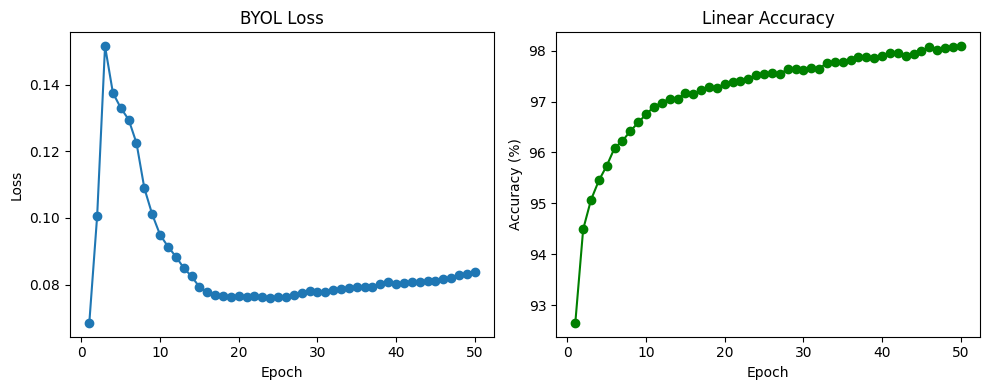

In [23]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(range(1, len(loss_list)+1), loss_list, marker='o')
plt.title("BYOL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(range(1, len(acc_list)+1), acc_list, marker='o', color='green')
plt.title("Linear Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.tight_layout()
plt.show()

## Trace Cov

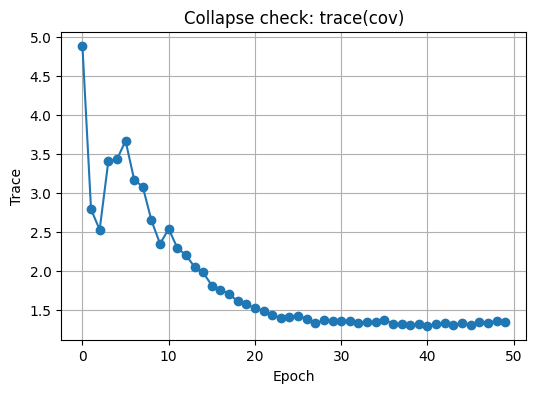

In [24]:
plt.figure(figsize=(6,4))
plt.plot(trace_list, marker='o')
plt.title("Collapse check: trace(cov)")
plt.xlabel("Epoch")
plt.ylabel("Trace")
plt.grid(True)
plt.show()


## TSNE График

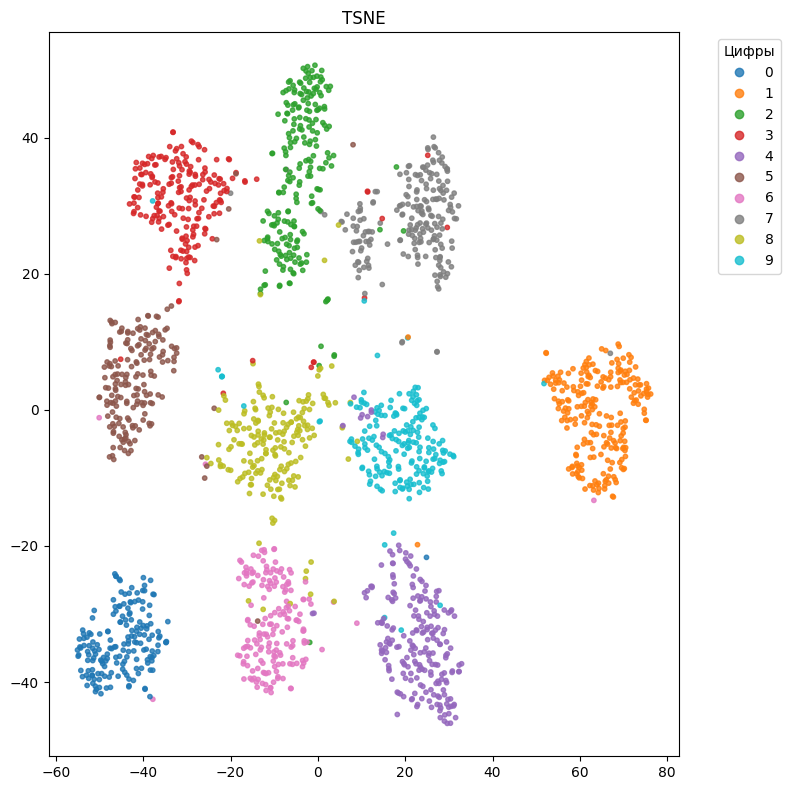

In [25]:
from sklearn.manifold import TSNE

def visualize_embeddings_tsne(encoder, dataloader, device, n_samples=2000):
    encoder.eval()
    feats_list = []
    labels_list = []

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            feats_list.append(feats.cpu())
            labels_list.append(y.cpu())
            if len(torch.cat(labels_list)) >= n_samples:
                break

    feats = torch.cat(feats_list)[:n_samples]
    labels = torch.cat(labels_list)[:n_samples]

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    emb_2d = tsne.fit_transform(feats.numpy())

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Цифры", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("TSNE")
    plt.tight_layout()
    plt.show()

visualize_embeddings_tsne(frozen_encoder, test_loader, device)

## Матрица ошибок

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [27]:
def plot_confusion_matrix(encoder, linear, test_loader, device):
    encoder.eval()
    linear.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            feats = encoder(x)
            preds = linear(feats).argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title("Матрица ошибок - BYOL")
    plt.show()


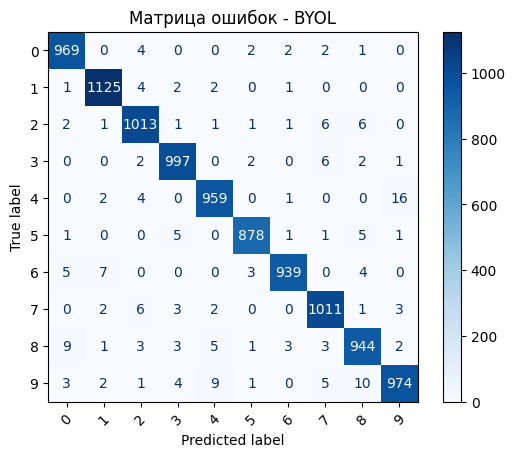

In [28]:
plot_confusion_matrix(frozen_encoder, _, test_loader, device)

## Прогон по нескольким сидам

In [29]:
import json

def sweep_tau(tau_list, seeds=[42, 123, 456], pretrain_epochs=25, linear_epochs=50, save_path="tau_sweep_results.json"):
    results = {}

    for tau in tau_list:
        acc_per_seed = []
        print(f"\n=== Tau = {tau} ===")
        for seed in seeds:
            print(f"\nSeed {seed}...")
            # Установка сида
            random.seed(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

            # Даталоадеры
            pretrain_loader, train_loader, test_loader = make_dataloaders()

            # Модель и BYOL
            encoder = Encoder(rep_dim=128)
            byol = BYOL(encoder, projector_dim=64, pred_hidden=128, tau=tau)
            student_params = list(byol.student_encoder.parameters()) + list(byol.student_projector.parameters()) + list(byol.student_predictor.parameters())
            optimizer = torch.optim.Adam(student_params, lr=1e-3, weight_decay=1e-6)

            # Предобучение BYOL
            _ = train_byol(byol, pretrain_loader, optimizer, device, epochs=pretrain_epochs, tau=tau)

            # Линейная оценка
            frozen_encoder = byol.student_encoder
            _, acc_list = train_linear(frozen_encoder, train_loader, test_loader, device, epochs=linear_epochs, lr=1e-3)
            final_acc = acc_list[-1]  # Берем последнюю эпоху

            acc_per_seed.append(final_acc)
            print(f"Seed {seed} finished: final linear eval acc = {final_acc:.2f}%")

        # Сохраняем результаты по tau
        mean_acc = float(np.mean(acc_per_seed))
        std_acc = float(np.std(acc_per_seed))
        results[str(tau)] = {
            "seed_accuracies": acc_per_seed,
            "mean": mean_acc,
            "std": std_acc
        }

        print(f"\nTau={tau}: mean={mean_acc:.2f}%, std={std_acc:.2f}%")

    # Сохраняем в JSON
    with open(save_path, "w") as f:
        json.dump(results, f, indent=4)

    print(f"\nAll results saved to {save_path}")
    return results


In [30]:
tau_values = [0.98]
results = sweep_tau(tau_values, save_path="tau_98")



=== Tau = 0.98 ===

Seed 42...


BYOL epoch 1/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 1: BYOL loss = 0.2445, trace(cov) = 1.99


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 2: BYOL loss = 0.2176, trace(cov) = 1.45


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 3: BYOL loss = 0.1600, trace(cov) = 1.40


BYOL epoch 4/25: 100%|██████████| 234/234 [01:14<00:00,  3.12it/s]


Epoch 4: BYOL loss = 0.1331, trace(cov) = 1.01


BYOL epoch 5/25: 100%|██████████| 234/234 [01:15<00:00,  3.11it/s]


Epoch 5: BYOL loss = 0.1159, trace(cov) = 0.98


BYOL epoch 6/25: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s]


Epoch 6: BYOL loss = 0.1060, trace(cov) = 0.89


BYOL epoch 7/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 7: BYOL loss = 0.1008, trace(cov) = 0.91


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 8: BYOL loss = 0.0976, trace(cov) = 0.82


BYOL epoch 9/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 9: BYOL loss = 0.0961, trace(cov) = 0.82


BYOL epoch 10/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 10: BYOL loss = 0.0943, trace(cov) = 0.82


BYOL epoch 11/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 11: BYOL loss = 0.0938, trace(cov) = 0.81


BYOL epoch 12/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 12: BYOL loss = 0.0939, trace(cov) = 0.82


BYOL epoch 13/25: 100%|██████████| 234/234 [01:14<00:00,  3.13it/s]


Epoch 13: BYOL loss = 0.0930, trace(cov) = 0.79


BYOL epoch 14/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 14: BYOL loss = 0.0926, trace(cov) = 0.79


BYOL epoch 15/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 15: BYOL loss = 0.0930, trace(cov) = 0.81


BYOL epoch 16/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 16: BYOL loss = 0.0937, trace(cov) = 0.83


BYOL epoch 17/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 17: BYOL loss = 0.0947, trace(cov) = 0.81


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 18: BYOL loss = 0.0956, trace(cov) = 0.82


BYOL epoch 19/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 19: BYOL loss = 0.0968, trace(cov) = 0.83


BYOL epoch 20/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 20: BYOL loss = 0.0970, trace(cov) = 0.85


BYOL epoch 21/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 21: BYOL loss = 0.0966, trace(cov) = 0.86


BYOL epoch 22/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 22: BYOL loss = 0.0972, trace(cov) = 0.87


BYOL epoch 23/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 23: BYOL loss = 0.0976, trace(cov) = 0.86


BYOL epoch 24/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 24: BYOL loss = 0.0977, trace(cov) = 0.88


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.16it/s]


Epoch 25: BYOL loss = 0.0981, trace(cov) = 0.90
Linear eval epoch 1: loss=1.8698, acc=93.20%
Linear eval epoch 2: loss=1.1975, acc=94.29%
Linear eval epoch 3: loss=0.8193, acc=94.94%
Linear eval epoch 4: loss=0.6077, acc=95.24%
Linear eval epoch 5: loss=0.4808, acc=95.46%
Linear eval epoch 6: loss=0.3988, acc=95.65%
Linear eval epoch 7: loss=0.3420, acc=95.95%
Linear eval epoch 8: loss=0.3005, acc=96.16%
Linear eval epoch 9: loss=0.2689, acc=96.26%
Linear eval epoch 10: loss=0.2442, acc=96.47%
Linear eval epoch 11: loss=0.2243, acc=96.56%
Linear eval epoch 12: loss=0.2079, acc=96.61%
Linear eval epoch 13: loss=0.1942, acc=96.73%
Linear eval epoch 14: loss=0.1825, acc=96.90%
Linear eval epoch 15: loss=0.1724, acc=96.98%
Linear eval epoch 16: loss=0.1638, acc=97.03%
Linear eval epoch 17: loss=0.1562, acc=97.08%
Linear eval epoch 18: loss=0.1494, acc=97.08%
Linear eval epoch 19: loss=0.1435, acc=97.16%
Linear eval epoch 20: loss=0.1381, acc=97.27%
Linear eval epoch 21: loss=0.1334, acc=97

BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 1: BYOL loss = 0.2737, trace(cov) = 4.33


BYOL epoch 2/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 2: BYOL loss = 0.1972, trace(cov) = 2.50


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 3: BYOL loss = 0.1562, trace(cov) = 2.54


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 4: BYOL loss = 0.1260, trace(cov) = 1.63


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 5: BYOL loss = 0.1076, trace(cov) = 1.44


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 6: BYOL loss = 0.0963, trace(cov) = 1.23


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 7: BYOL loss = 0.0946, trace(cov) = 1.04


BYOL epoch 8/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 8: BYOL loss = 0.0934, trace(cov) = 0.90


BYOL epoch 9/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 9: BYOL loss = 0.0909, trace(cov) = 0.83


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 10: BYOL loss = 0.0916, trace(cov) = 0.81


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 11: BYOL loss = 0.0901, trace(cov) = 0.80


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 12: BYOL loss = 0.0883, trace(cov) = 0.74


BYOL epoch 13/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 13: BYOL loss = 0.0893, trace(cov) = 0.77


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 14: BYOL loss = 0.0887, trace(cov) = 0.76


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 15: BYOL loss = 0.0897, trace(cov) = 0.80


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 16: BYOL loss = 0.0896, trace(cov) = 0.76


BYOL epoch 17/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 17: BYOL loss = 0.0899, trace(cov) = 0.77


BYOL epoch 18/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 18: BYOL loss = 0.0894, trace(cov) = 0.76


BYOL epoch 19/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 19: BYOL loss = 0.0912, trace(cov) = 0.77


BYOL epoch 20/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 20: BYOL loss = 0.0931, trace(cov) = 0.79


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 21: BYOL loss = 0.0929, trace(cov) = 0.80


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 22: BYOL loss = 0.0946, trace(cov) = 0.82


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 23: BYOL loss = 0.0947, trace(cov) = 0.84


BYOL epoch 24/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 24: BYOL loss = 0.0957, trace(cov) = 0.84


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 25: BYOL loss = 0.0963, trace(cov) = 0.87
Linear eval epoch 1: loss=1.8723, acc=91.64%
Linear eval epoch 2: loss=1.2114, acc=93.83%
Linear eval epoch 3: loss=0.8352, acc=94.41%
Linear eval epoch 4: loss=0.6232, acc=94.85%
Linear eval epoch 5: loss=0.4956, acc=95.01%
Linear eval epoch 6: loss=0.4124, acc=95.35%
Linear eval epoch 7: loss=0.3546, acc=95.51%
Linear eval epoch 8: loss=0.3123, acc=95.74%
Linear eval epoch 9: loss=0.2800, acc=95.92%
Linear eval epoch 10: loss=0.2546, acc=96.05%
Linear eval epoch 11: loss=0.2340, acc=96.11%
Linear eval epoch 12: loss=0.2172, acc=96.33%
Linear eval epoch 13: loss=0.2029, acc=96.39%
Linear eval epoch 14: loss=0.1908, acc=96.52%
Linear eval epoch 15: loss=0.1804, acc=96.59%
Linear eval epoch 16: loss=0.1713, acc=96.66%
Linear eval epoch 17: loss=0.1634, acc=96.76%
Linear eval epoch 18: loss=0.1564, acc=96.77%
Linear eval epoch 19: loss=0.1501, acc=96.90%
Linear eval epoch 20: loss=0.1446, acc=96.97%
Linear eval epoch 21: loss=0.1395, acc=96

BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 1: BYOL loss = 0.1335, trace(cov) = 2.97


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 2: BYOL loss = 0.1889, trace(cov) = 1.88


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 3: BYOL loss = 0.1747, trace(cov) = 0.77


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 4: BYOL loss = 0.1327, trace(cov) = 0.75


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 5: BYOL loss = 0.1116, trace(cov) = 0.74


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 6: BYOL loss = 0.1047, trace(cov) = 0.69


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 7: BYOL loss = 0.0973, trace(cov) = 0.64


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 8: BYOL loss = 0.0936, trace(cov) = 0.65


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 9: BYOL loss = 0.0914, trace(cov) = 0.67


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 10: BYOL loss = 0.0909, trace(cov) = 0.69


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 11: BYOL loss = 0.0916, trace(cov) = 0.67


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 12: BYOL loss = 0.0906, trace(cov) = 0.69


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 13: BYOL loss = 0.0915, trace(cov) = 0.69


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 14: BYOL loss = 0.0918, trace(cov) = 0.70


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 15: BYOL loss = 0.0910, trace(cov) = 0.68


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 16: BYOL loss = 0.0908, trace(cov) = 0.69


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 17: BYOL loss = 0.0909, trace(cov) = 0.73


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 18: BYOL loss = 0.0918, trace(cov) = 0.73


BYOL epoch 19/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 19: BYOL loss = 0.0921, trace(cov) = 0.75


BYOL epoch 20/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 20: BYOL loss = 0.0937, trace(cov) = 0.76


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.16it/s]


Epoch 21: BYOL loss = 0.0944, trace(cov) = 0.77


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 22: BYOL loss = 0.0951, trace(cov) = 0.78


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 23: BYOL loss = 0.0946, trace(cov) = 0.83


BYOL epoch 24/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 24: BYOL loss = 0.0955, trace(cov) = 0.82


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 25: BYOL loss = 0.0956, trace(cov) = 0.82
Linear eval epoch 1: loss=1.8719, acc=92.49%
Linear eval epoch 2: loss=1.2212, acc=94.41%
Linear eval epoch 3: loss=0.8421, acc=94.94%
Linear eval epoch 4: loss=0.6254, acc=95.27%
Linear eval epoch 5: loss=0.4942, acc=95.52%
Linear eval epoch 6: loss=0.4090, acc=95.67%
Linear eval epoch 7: loss=0.3499, acc=95.90%
Linear eval epoch 8: loss=0.3068, acc=96.02%
Linear eval epoch 9: loss=0.2741, acc=96.21%
Linear eval epoch 10: loss=0.2485, acc=96.36%
Linear eval epoch 11: loss=0.2278, acc=96.50%
Linear eval epoch 12: loss=0.2109, acc=96.56%
Linear eval epoch 13: loss=0.1967, acc=96.66%
Linear eval epoch 14: loss=0.1846, acc=96.77%
Linear eval epoch 15: loss=0.1744, acc=96.76%
Linear eval epoch 16: loss=0.1654, acc=96.88%
Linear eval epoch 17: loss=0.1577, acc=96.95%
Linear eval epoch 18: loss=0.1508, acc=97.05%
Linear eval epoch 19: loss=0.1446, acc=97.13%
Linear eval epoch 20: loss=0.1392, acc=97.17%
Linear eval epoch 21: loss=0.1343, acc=97

In [31]:
tau_values = [0.995]
results = sweep_tau(tau_values, save_path="tau_995")



=== Tau = 0.995 ===

Seed 42...


BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 1: BYOL loss = 0.0861, trace(cov) = 3.47


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 2: BYOL loss = 0.0692, trace(cov) = 2.50


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 3: BYOL loss = 0.1104, trace(cov) = 1.84


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 4: BYOL loss = 0.1216, trace(cov) = 1.72


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 5: BYOL loss = 0.1310, trace(cov) = 2.21


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 6: BYOL loss = 0.1319, trace(cov) = 2.02


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 7: BYOL loss = 0.1179, trace(cov) = 1.90


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 8: BYOL loss = 0.1052, trace(cov) = 1.86


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 9: BYOL loss = 0.0957, trace(cov) = 1.78


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 10: BYOL loss = 0.0888, trace(cov) = 1.68


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 11: BYOL loss = 0.0862, trace(cov) = 1.59


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 12: BYOL loss = 0.0837, trace(cov) = 1.43


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 13: BYOL loss = 0.0814, trace(cov) = 1.43


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 14: BYOL loss = 0.0819, trace(cov) = 1.36


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 15: BYOL loss = 0.0811, trace(cov) = 1.38


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 16: BYOL loss = 0.0808, trace(cov) = 1.38


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 17: BYOL loss = 0.0800, trace(cov) = 1.30


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 18: BYOL loss = 0.0797, trace(cov) = 1.29


BYOL epoch 19/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 19: BYOL loss = 0.0797, trace(cov) = 1.24


BYOL epoch 20/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 20: BYOL loss = 0.0793, trace(cov) = 1.26


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 21: BYOL loss = 0.0794, trace(cov) = 1.23


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 22: BYOL loss = 0.0799, trace(cov) = 1.24


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 23: BYOL loss = 0.0798, trace(cov) = 1.22


BYOL epoch 24/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 24: BYOL loss = 0.0796, trace(cov) = 1.22


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 25: BYOL loss = 0.0796, trace(cov) = 1.24
Linear eval epoch 1: loss=1.8396, acc=90.41%
Linear eval epoch 2: loss=1.1838, acc=92.38%
Linear eval epoch 3: loss=0.8323, acc=93.59%
Linear eval epoch 4: loss=0.6344, acc=94.19%
Linear eval epoch 5: loss=0.5133, acc=94.41%
Linear eval epoch 6: loss=0.4333, acc=94.72%
Linear eval epoch 7: loss=0.3773, acc=94.99%
Linear eval epoch 8: loss=0.3359, acc=95.10%
Linear eval epoch 9: loss=0.3040, acc=95.29%
Linear eval epoch 10: loss=0.2789, acc=95.32%
Linear eval epoch 11: loss=0.2586, acc=95.47%
Linear eval epoch 12: loss=0.2418, acc=95.65%
Linear eval epoch 13: loss=0.2277, acc=95.69%
Linear eval epoch 14: loss=0.2158, acc=95.74%
Linear eval epoch 15: loss=0.2053, acc=95.90%
Linear eval epoch 16: loss=0.1964, acc=95.98%
Linear eval epoch 17: loss=0.1886, acc=96.03%
Linear eval epoch 18: loss=0.1816, acc=96.08%
Linear eval epoch 19: loss=0.1754, acc=96.14%
Linear eval epoch 20: loss=0.1698, acc=96.14%
Linear eval epoch 21: loss=0.1649, acc=96

BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 1: BYOL loss = 0.0645, trace(cov) = 6.64


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 2: BYOL loss = 0.1365, trace(cov) = 3.33


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 3: BYOL loss = 0.1730, trace(cov) = 2.85


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 4: BYOL loss = 0.1608, trace(cov) = 3.55


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 5: BYOL loss = 0.1597, trace(cov) = 3.77


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 6: BYOL loss = 0.1472, trace(cov) = 3.57


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 7: BYOL loss = 0.1416, trace(cov) = 3.03


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 8: BYOL loss = 0.1309, trace(cov) = 3.39


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 9: BYOL loss = 0.1168, trace(cov) = 3.09


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 10: BYOL loss = 0.1057, trace(cov) = 2.35


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 11: BYOL loss = 0.0974, trace(cov) = 2.32


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 12: BYOL loss = 0.0916, trace(cov) = 2.07


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 13: BYOL loss = 0.0894, trace(cov) = 2.12


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 14: BYOL loss = 0.0870, trace(cov) = 1.75


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 15: BYOL loss = 0.0854, trace(cov) = 1.88


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 16: BYOL loss = 0.0844, trace(cov) = 1.75


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 17: BYOL loss = 0.0831, trace(cov) = 1.64


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 18: BYOL loss = 0.0811, trace(cov) = 1.57


BYOL epoch 19/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 19: BYOL loss = 0.0801, trace(cov) = 1.49


BYOL epoch 20/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 20: BYOL loss = 0.0793, trace(cov) = 1.52


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 21: BYOL loss = 0.0770, trace(cov) = 1.47


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 22: BYOL loss = 0.0769, trace(cov) = 1.50


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 23: BYOL loss = 0.0769, trace(cov) = 1.47


BYOL epoch 24/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 24: BYOL loss = 0.0767, trace(cov) = 1.48


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 25: BYOL loss = 0.0767, trace(cov) = 1.40
Linear eval epoch 1: loss=1.8343, acc=89.32%
Linear eval epoch 2: loss=1.2022, acc=92.20%
Linear eval epoch 3: loss=0.8606, acc=92.91%
Linear eval epoch 4: loss=0.6646, acc=93.75%
Linear eval epoch 5: loss=0.5428, acc=93.76%
Linear eval epoch 6: loss=0.4613, acc=94.16%
Linear eval epoch 7: loss=0.4038, acc=94.41%
Linear eval epoch 8: loss=0.3610, acc=94.57%
Linear eval epoch 9: loss=0.3281, acc=94.78%
Linear eval epoch 10: loss=0.3021, acc=94.87%
Linear eval epoch 11: loss=0.2809, acc=95.01%
Linear eval epoch 12: loss=0.2635, acc=95.26%
Linear eval epoch 13: loss=0.2487, acc=95.30%
Linear eval epoch 14: loss=0.2362, acc=95.37%
Linear eval epoch 15: loss=0.2254, acc=95.41%
Linear eval epoch 16: loss=0.2159, acc=95.50%
Linear eval epoch 17: loss=0.2077, acc=95.55%
Linear eval epoch 18: loss=0.2003, acc=95.71%
Linear eval epoch 19: loss=0.1938, acc=95.76%
Linear eval epoch 20: loss=0.1880, acc=95.82%
Linear eval epoch 21: loss=0.1826, acc=95

BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 1: BYOL loss = 0.0548, trace(cov) = 14.81


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 2: BYOL loss = 0.0048, trace(cov) = 30.42


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 3: BYOL loss = 0.1011, trace(cov) = 20.82


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 4: BYOL loss = 0.1613, trace(cov) = 7.78


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 5: BYOL loss = 0.1327, trace(cov) = 6.34


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 6: BYOL loss = 0.1237, trace(cov) = 5.59


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 7: BYOL loss = 0.1149, trace(cov) = 3.36


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 8: BYOL loss = 0.1023, trace(cov) = 2.81


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 9: BYOL loss = 0.0920, trace(cov) = 2.22


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 10: BYOL loss = 0.0857, trace(cov) = 2.07


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 11: BYOL loss = 0.0811, trace(cov) = 1.85


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 12: BYOL loss = 0.0767, trace(cov) = 1.74


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 13: BYOL loss = 0.0758, trace(cov) = 1.59


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 14: BYOL loss = 0.0739, trace(cov) = 1.54


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 15: BYOL loss = 0.0733, trace(cov) = 1.43


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 16: BYOL loss = 0.0731, trace(cov) = 1.40


BYOL epoch 17/25: 100%|██████████| 234/234 [01:14<00:00,  3.14it/s]


Epoch 17: BYOL loss = 0.0728, trace(cov) = 1.39


BYOL epoch 18/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 18: BYOL loss = 0.0740, trace(cov) = 1.41


BYOL epoch 19/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 19: BYOL loss = 0.0740, trace(cov) = 1.37


BYOL epoch 20/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 20: BYOL loss = 0.0752, trace(cov) = 1.34


BYOL epoch 21/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 21: BYOL loss = 0.0754, trace(cov) = 1.33


BYOL epoch 22/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 22: BYOL loss = 0.0753, trace(cov) = 1.29


BYOL epoch 23/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 23: BYOL loss = 0.0753, trace(cov) = 1.32


BYOL epoch 24/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 24: BYOL loss = 0.0756, trace(cov) = 1.31


BYOL epoch 25/25: 100%|██████████| 234/234 [01:14<00:00,  3.15it/s]


Epoch 25: BYOL loss = 0.0758, trace(cov) = 1.28
Linear eval epoch 1: loss=1.8083, acc=91.17%
Linear eval epoch 2: loss=1.1260, acc=93.25%
Linear eval epoch 3: loss=0.7767, acc=94.16%
Linear eval epoch 4: loss=0.5883, acc=94.68%
Linear eval epoch 5: loss=0.4759, acc=94.92%
Linear eval epoch 6: loss=0.4028, acc=95.12%
Linear eval epoch 7: loss=0.3517, acc=95.32%
Linear eval epoch 8: loss=0.3140, acc=95.41%
Linear eval epoch 9: loss=0.2854, acc=95.57%
Linear eval epoch 10: loss=0.2626, acc=95.76%
Linear eval epoch 11: loss=0.2442, acc=95.77%
Linear eval epoch 12: loss=0.2289, acc=95.93%
Linear eval epoch 13: loss=0.2162, acc=95.98%
Linear eval epoch 14: loss=0.2051, acc=96.13%
Linear eval epoch 15: loss=0.1958, acc=96.23%
Linear eval epoch 16: loss=0.1875, acc=96.31%
Linear eval epoch 17: loss=0.1804, acc=96.27%
Linear eval epoch 18: loss=0.1740, acc=96.44%
Linear eval epoch 19: loss=0.1682, acc=96.42%
Linear eval epoch 20: loss=0.1632, acc=96.50%
Linear eval epoch 21: loss=0.1585, acc=96

In [32]:
tau_values = [0.999]
results = sweep_tau(tau_values, save_path="tau_999")



=== Tau = 0.999 ===

Seed 42...


BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 1: BYOL loss = 0.0679, trace(cov) = 8.77


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 2: BYOL loss = 0.0036, trace(cov) = 9.00


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 3: BYOL loss = 0.0044, trace(cov) = 8.45


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 4: BYOL loss = 0.0058, trace(cov) = 7.63


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 5: BYOL loss = 0.0102, trace(cov) = 6.44


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 6: BYOL loss = 0.0177, trace(cov) = 5.35


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 7: BYOL loss = 0.0273, trace(cov) = 4.45


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 8: BYOL loss = 0.0329, trace(cov) = 3.24


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 9: BYOL loss = 0.0416, trace(cov) = 4.26


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 10: BYOL loss = 0.0527, trace(cov) = 3.49


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 11: BYOL loss = 0.0651, trace(cov) = 3.73


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 12: BYOL loss = 0.0748, trace(cov) = 3.61


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 13: BYOL loss = 0.0861, trace(cov) = 4.12


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 14: BYOL loss = 0.0951, trace(cov) = 3.62


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 15: BYOL loss = 0.0984, trace(cov) = 5.06


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 16: BYOL loss = 0.1015, trace(cov) = 4.88


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 17: BYOL loss = 0.1028, trace(cov) = 4.52


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 18: BYOL loss = 0.1036, trace(cov) = 4.98


BYOL epoch 19/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 19: BYOL loss = 0.1055, trace(cov) = 5.01


BYOL epoch 20/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 20: BYOL loss = 0.1047, trace(cov) = 5.14


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 21: BYOL loss = 0.1067, trace(cov) = 5.44


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 22: BYOL loss = 0.1052, trace(cov) = 5.32


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 23: BYOL loss = 0.1033, trace(cov) = 5.10


BYOL epoch 24/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 24: BYOL loss = 0.1005, trace(cov) = 5.38


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 25: BYOL loss = 0.0997, trace(cov) = 4.86
Linear eval epoch 1: loss=1.8630, acc=63.79%
Linear eval epoch 2: loss=1.4146, acc=71.99%
Linear eval epoch 3: loss=1.1916, acc=75.48%
Linear eval epoch 4: loss=1.0501, acc=77.83%
Linear eval epoch 5: loss=0.9516, acc=80.08%
Linear eval epoch 6: loss=0.8774, acc=81.05%
Linear eval epoch 7: loss=0.8198, acc=82.05%
Linear eval epoch 8: loss=0.7725, acc=83.07%
Linear eval epoch 9: loss=0.7335, acc=83.11%
Linear eval epoch 10: loss=0.7003, acc=83.67%
Linear eval epoch 11: loss=0.6717, acc=84.30%
Linear eval epoch 12: loss=0.6471, acc=84.83%
Linear eval epoch 13: loss=0.6247, acc=85.18%
Linear eval epoch 14: loss=0.6053, acc=85.11%
Linear eval epoch 15: loss=0.5873, acc=86.14%
Linear eval epoch 16: loss=0.5713, acc=86.18%
Linear eval epoch 17: loss=0.5571, acc=86.40%
Linear eval epoch 18: loss=0.5436, acc=86.54%
Linear eval epoch 19: loss=0.5315, acc=86.85%
Linear eval epoch 20: loss=0.5200, acc=87.28%
Linear eval epoch 21: loss=0.5098, acc=87

BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 1: BYOL loss = 0.0437, trace(cov) = 7.44


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 2: BYOL loss = 0.0015, trace(cov) = 7.49


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 3: BYOL loss = 0.0015, trace(cov) = 7.45


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 4: BYOL loss = 0.0036, trace(cov) = 6.33


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.20it/s]


Epoch 5: BYOL loss = 0.0150, trace(cov) = 7.63


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 6: BYOL loss = 0.0405, trace(cov) = 5.74


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 7: BYOL loss = 0.0670, trace(cov) = 6.77


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 8: BYOL loss = 0.0926, trace(cov) = 5.82


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 9: BYOL loss = 0.1160, trace(cov) = 6.78


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 10: BYOL loss = 0.1242, trace(cov) = 5.75


BYOL epoch 11/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 11: BYOL loss = 0.1211, trace(cov) = 5.39


BYOL epoch 12/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 12: BYOL loss = 0.1128, trace(cov) = 5.22


BYOL epoch 13/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 13: BYOL loss = 0.1037, trace(cov) = 5.29


BYOL epoch 14/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 14: BYOL loss = 0.1022, trace(cov) = 4.52


BYOL epoch 15/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 15: BYOL loss = 0.1033, trace(cov) = 5.28


BYOL epoch 16/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 16: BYOL loss = 0.1058, trace(cov) = 6.06


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.16it/s]


Epoch 17: BYOL loss = 0.1092, trace(cov) = 7.16


BYOL epoch 18/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 18: BYOL loss = 0.1126, trace(cov) = 6.65


BYOL epoch 19/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 19: BYOL loss = 0.1147, trace(cov) = 5.34


BYOL epoch 20/25: 100%|██████████| 234/234 [01:13<00:00,  3.17it/s]


Epoch 20: BYOL loss = 0.1180, trace(cov) = 5.84


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 21: BYOL loss = 0.1185, trace(cov) = 5.95


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 22: BYOL loss = 0.1191, trace(cov) = 5.58


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 23: BYOL loss = 0.1182, trace(cov) = 6.41


BYOL epoch 24/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 24: BYOL loss = 0.1163, trace(cov) = 5.72


BYOL epoch 25/25: 100%|██████████| 234/234 [01:14<00:00,  3.16it/s]


Epoch 25: BYOL loss = 0.1166, trace(cov) = 6.48
Linear eval epoch 1: loss=1.9157, acc=50.51%
Linear eval epoch 2: loss=1.5686, acc=60.01%
Linear eval epoch 3: loss=1.3970, acc=60.86%
Linear eval epoch 4: loss=1.2854, acc=64.97%
Linear eval epoch 5: loss=1.2055, acc=66.51%
Linear eval epoch 6: loss=1.1444, acc=67.89%
Linear eval epoch 7: loss=1.0948, acc=70.10%
Linear eval epoch 8: loss=1.0540, acc=71.31%
Linear eval epoch 9: loss=1.0196, acc=71.69%
Linear eval epoch 10: loss=0.9893, acc=72.49%
Linear eval epoch 11: loss=0.9622, acc=73.64%
Linear eval epoch 12: loss=0.9386, acc=73.85%
Linear eval epoch 13: loss=0.9170, acc=74.93%
Linear eval epoch 14: loss=0.8976, acc=75.92%
Linear eval epoch 15: loss=0.8795, acc=76.56%
Linear eval epoch 16: loss=0.8631, acc=76.45%
Linear eval epoch 17: loss=0.8478, acc=77.54%
Linear eval epoch 18: loss=0.8338, acc=77.30%
Linear eval epoch 19: loss=0.8203, acc=78.03%
Linear eval epoch 20: loss=0.8079, acc=78.43%
Linear eval epoch 21: loss=0.7966, acc=78

BYOL epoch 1/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 1: BYOL loss = 0.0459, trace(cov) = 13.49


BYOL epoch 2/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 2: BYOL loss = 0.0008, trace(cov) = 14.28


BYOL epoch 3/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 3: BYOL loss = 0.0003, trace(cov) = 14.02


BYOL epoch 4/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 4: BYOL loss = 0.0002, trace(cov) = 13.36


BYOL epoch 5/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 5: BYOL loss = 0.0002, trace(cov) = 12.62


BYOL epoch 6/25: 100%|██████████| 234/234 [01:13<00:00,  3.18it/s]


Epoch 6: BYOL loss = 0.0002, trace(cov) = 12.18


BYOL epoch 7/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 7: BYOL loss = 0.0003, trace(cov) = 11.30


BYOL epoch 8/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 8: BYOL loss = 0.0015, trace(cov) = 10.27


BYOL epoch 9/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 9: BYOL loss = 0.0114, trace(cov) = 8.99


BYOL epoch 10/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 10: BYOL loss = 0.0438, trace(cov) = 6.62


BYOL epoch 11/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 11: BYOL loss = 0.0705, trace(cov) = 9.49


BYOL epoch 12/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 12: BYOL loss = 0.0864, trace(cov) = 6.88


BYOL epoch 13/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 13: BYOL loss = 0.1013, trace(cov) = 6.11


BYOL epoch 14/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 14: BYOL loss = 0.1042, trace(cov) = 5.00


BYOL epoch 15/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 15: BYOL loss = 0.1029, trace(cov) = 6.16


BYOL epoch 16/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 16: BYOL loss = 0.0970, trace(cov) = 4.36


BYOL epoch 17/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 17: BYOL loss = 0.0961, trace(cov) = 7.93


BYOL epoch 18/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 18: BYOL loss = 0.0959, trace(cov) = 6.19


BYOL epoch 19/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 19: BYOL loss = 0.0942, trace(cov) = 5.31


BYOL epoch 20/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 20: BYOL loss = 0.0945, trace(cov) = 5.59


BYOL epoch 21/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 21: BYOL loss = 0.0948, trace(cov) = 5.51


BYOL epoch 22/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 22: BYOL loss = 0.0943, trace(cov) = 5.74


BYOL epoch 23/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 23: BYOL loss = 0.0927, trace(cov) = 5.35


BYOL epoch 24/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 24: BYOL loss = 0.0925, trace(cov) = 5.44


BYOL epoch 25/25: 100%|██████████| 234/234 [01:13<00:00,  3.19it/s]


Epoch 25: BYOL loss = 0.0889, trace(cov) = 5.12
Linear eval epoch 1: loss=1.8133, acc=59.08%
Linear eval epoch 2: loss=1.4128, acc=65.70%
Linear eval epoch 3: loss=1.2279, acc=69.20%
Linear eval epoch 4: loss=1.1118, acc=72.23%
Linear eval epoch 5: loss=1.0301, acc=73.88%
Linear eval epoch 6: loss=0.9682, acc=74.84%
Linear eval epoch 7: loss=0.9193, acc=75.74%
Linear eval epoch 8: loss=0.8785, acc=76.78%
Linear eval epoch 9: loss=0.8452, acc=77.39%
Linear eval epoch 10: loss=0.8158, acc=78.24%
Linear eval epoch 11: loss=0.7905, acc=78.75%
Linear eval epoch 12: loss=0.7684, acc=79.20%
Linear eval epoch 13: loss=0.7482, acc=79.55%
Linear eval epoch 14: loss=0.7305, acc=79.99%
Linear eval epoch 15: loss=0.7148, acc=80.49%
Linear eval epoch 16: loss=0.6999, acc=80.57%
Linear eval epoch 17: loss=0.6867, acc=80.91%
Linear eval epoch 18: loss=0.6743, acc=81.40%
Linear eval epoch 19: loss=0.6630, acc=81.67%
Linear eval epoch 20: loss=0.6523, acc=81.94%
Linear eval epoch 21: loss=0.6427, acc=82